Instructions 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

7) FW for DNNs

1) Analize in depth the approaches described in the papers and the 
theory related to them.

2) Compare the  ORGFW, SFW, MSFW and SVRF (using the l1 ball as a 
constraint) following the lines of the experiments carried    out in 
section 5 using two new datasets (using your own code).

# Optimization for Data Science - Final Project

@authors

Rodrigo Arriaza

Ivan Kulazhenkov

Sebastian Rojas

Andres Aranguren

# Pytorch implementation

## LMO Oracles

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from sklearn.model_selection import train_test_split

In [2]:
def LMO_l1(grad, kappa):
    shape = grad.shape
    grad = grad.reshape(-1)
    s = np.zeros(grad.shape)
    coord = np.argmax(np.abs(grad))
    s[coord] = kappa * np.sign(grad[coord])
    return - s.reshape(*shape)

# Optimizers

## Stochastic Frank Wolfe

In [3]:
class SGDFWl1(Optimizer):
    """Stochastic Frank Wolfe with |vec(W_i)|_1 <= kappa_l1 where W_i are parameter sets
    """
    def __init__(self, params, kappa_l1):
        self.k = 0
        assert kappa_l1 > 0
        defaults = dict(kappa=kappa_l1)
        super(SGDFWl1, self).__init__(params, defaults)

    def step(self, **kwargs):
        loss = None
        for group in self.param_groups:
            kappa = group['kappa']
            for p in group['params']:
                if p.grad is None:
                    continue
                s = LMO_l1(p.grad.data.numpy(), kappa)
                gamma = 2 / (self.k + 2)
                delta_p = torch.Tensor(gamma * s - gamma * p.data.numpy())
                p.data.add_(delta_p)
        self.k += 1
        return loss, None, None

## MSFW

In [5]:
class MSGDFWl1(Optimizer):
    """Stochastic Frank Wolfe with |vec(W_i)|_1 <= kappa_l1 where W_i are parameter sets
    """
    def __init__(self, params, kappa_l1, momentum):
        self.k = 0
        assert kappa_l1 > 0
        defaults = dict(kappa=kappa_l1)
        self.momentum = momentum
        super(MSGDFWl1, self).__init__(params, defaults)

    def step(self, **kwargs):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        momentum = self.momentum
        for group in self.param_groups:
            kappa = group['kappa']

            for p in group['params']:
                if p.grad is None:
                    continue
                s = LMO_l1(p.grad.data.numpy(), kappa)
                gamma = 2 / (self.k + 2)
                # x^(k+1) = x^(k) - g x^(k) + g s

                # with momentum
                # x^(k+1) = x^(k) - g (x^(k) + s)
                s = (1 - momentum)*s + momentum * p.grad.data.numpy()
                # x^(k+1) = x^(k) + g(s - x^(k))
                delta_p = torch.Tensor(gamma * s - gamma * p.data.numpy())
                p.data.add_(delta_p)
                # p = delta_p

        self.k += 1
        return loss, None, None

## ORGFW

In [6]:
class ORGFWl1(Optimizer):
    """Stochastic Frank Wolfe with |vec(W_i)|_1 <= kappa_l1 where W_i are parameter sets
    """
    def __init__(self, params, kappa_l1, lr, batch_size, momentum):
        self.k = 0
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        assert kappa_l1 > 0
        defaults = dict(kappa=kappa_l1)
        super(ORGFWl1, self).__init__(params, defaults)

    def step(self, **kwargs):
        #closure=None, last_mt=None, epoch=None, last_p=None
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        #print(kwargs) {'last_mt': None, 'epoch': 1, 'last_p': None}
        last_mt = kwargs['last_mt']
        epoch = kwargs['epoch']
        last_p = kwargs['last_p']
        loss = None
        batch_size = self.batch_size
        lr = self.lr
        momentum = self.momentum
        mt = []
        p_old = []
        for group in self.param_groups:
            kappa = group['kappa']
            for i in range(len(group['params'])):
                p = group['params'][i]
                p_old.append(p)
                gamma = 2 / (self.k + 2)
                if p.grad is None:
                    continue
                s = LMO_l1(p.grad.data.numpy(), kappa)
                if (last_mt is not None and last_p is not None and epoch > 1):
                    #print(np.sum(last_mt[i] - last_p[i].grad.numpy() ))
                    last_s = LMO_l1(last_p[i].grad.numpy(), kappa)
                    s = s + (1 - momentum) * (last_mt[i] - last_s)
                mt.append(s)
                delta_p = torch.Tensor(gamma * s - gamma * p.data.numpy())
                p.data.add_(delta_p)
        self.k += 1
        return loss, mt, p_old

## SVRF

In [7]:
import torch
from torch.optim import Optimizer
from collections import defaultdict
import random

class SVRF(Optimizer):
    """Stochastic Frank Wolfe with |vec(W_i)|_1 <= kappa_l1 where W_i are parameter sets
    """
    def __init__(self, params, kappa_l1,momentum, lr, batch_size):
        self.k = 0
        assert kappa_l1 > 0
        defaults = dict(kappa=kappa_l1)
        super(SVRF, self).__init__(params, defaults)

    def step(self, **kwargs):
        last_snap = kwargs['last_snap']
        loss_snap = kwargs['loss_snap']
        snapshot = kwargs['snapshot']
        loss = None
        snap_ar = []
        #sample_ds = self.sample_ds(ds, 12)
        for group in self.param_groups:
            kappa = group['kappa']
            for i in range(len(group['params'])):
                p = group['params'][i]
                if p.grad is None:
                    continue
                if last_snap is None or len(last_snap) == 0:
                    #print('entre')
                    i_snap = LMO_l1(p.grad.data.numpy(), kappa)
                    snap_ar.append(i_snap)
                    gamma = 2 / (self.k + 2)
                else:
                    gamma = 2 / (self.k + 2)
                    s = LMO_l1(p.grad.data.numpy(), kappa)
                    s0 = snapshot[i]
                    L_xk = s - (s0 - loss_snap[i])
                    #L_xk = loss_snap[i] + s-last_snap[i]
                    delta_p = torch.Tensor(gamma*(L_xk-p.data.numpy()))
                    p.data.add_(delta_p)
                #s = (1 - momentum)*s + momentum * p.grad.data.numpy()
        self.k += 1
        return loss,snap_ar,None
    
    def sample_ds(self, ds, size):
        indices = random.sample(range(0, len(ds)), size)
        indices.sort()
        subset = torch.utils.data.Subset(ds, indices)
        trainloader = torch.utils.data.DataLoader(subset, batch_size=64,shuffle=True)
        return trainloader

    def snapshot(self):
        weights = defaultdict(int)
        for group in self.param_groups:
            layers = len(group['params'])
            for i in range(layers):
                p = group['params'][i]
                if (p.grad is None):
                    continue
                weights[i] = p.grad.data.numpy()
        return weights

    def loss_snapshot(self, dataset):
        grads = defaultdict(int)
        total = 0
        for batch_idx, (x, target) in enumerate(dataset):
            for group in self.param_groups:
                layers = len(group['params'])
                for i in range(layers):
                    p = group['params'][i]
                    if (p.grad is None):
                        continue
                    grads[i] += p.grad.data.numpy()
            total += 1
        for i in range(layers):
            grads[i] = grads[i] / total
        return grads



# Model

In [35]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import time

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 80)
        self.fc2 = nn.Linear(80, 80)
        self.fc3 = nn.Linear(80, 80)
        self.fc4 = nn.Linear(80, 10)
        self.layers = [self.fc1, self.fc2, self.fc3, self.fc4]

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

def train_model(model, optimizer, criterion, epochs, train_loader, test_loader, print_progress=True):
    """ trains a model using a given optimizer and criterion. 
    """
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    train_loss, test_error = [], []
    start_t = time.time()
    time_elapsed = []
    last_mt = None
    p_old = None
    for epoch in range(1, epochs+1):
        sum_loss = 0
        n_correct = 0
        n_samples = 0
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            x, target = Variable(x), Variable(target)
            out = model(x)
            _, pred_label = torch.max(out.data, 1)
            n_samples += x.data.size()[0]
            n_correct += (pred_label == target.data).sum().numpy()
            loss = criterion(out, target)
            sum_loss += loss.item()
            loss.backward()
            params = {'last_mt': last_mt, 'epoch': epoch, 'last_p': p_old}
            _, mt, p = optimizer.step(**params)
            last_mt = mt
            p_old = p
        # testing
        sum_loss = 0
        n_correct = 0
        n_samples = 0
        for batch_idx, (x, target) in enumerate(test_loader):
            with torch.no_grad():
                x, target = Variable(x), Variable(target)
            out = model(x)

            _, pred_label = torch.max(out.data, 1)
            n_samples += x.data.size()[0]
            n_correct += (pred_label == target.data).sum().numpy()

            loss = criterion(out, target)
            sum_loss += loss.item()
        test_loss.append(sum_loss / n_samples)
        test_acc.append(n_correct / n_samples)
        train_loss.append(sum_loss / n_samples)
        train_acc.append(n_correct / n_samples)
        t_epoch = time.time()-start_t
        time_elapsed.append(t_epoch)

        if print_progress:
            lt, at = train_loss[-1], train_acc[-1]
            lte, ate = test_loss[-1], test_acc[-1]
            print('Epoch {e}: train: {lt} loss, {at} acc; test: {lte} loss, {ate} acc, time {t}'
                  .format(e=epoch, lt=lt, at=at, lte=lte, ate=ate, t=t_epoch))

    metrics = {'train': {'loss': train_loss, 'acc': train_acc},
               'test': {'loss': test_loss, 'acc': test_acc},
               'time_elapsed':time_elapsed}
    return model, metrics

    def train_model_svrf(model, optimizer, criterion, epochs, train_loader, test_loader, print_progress=True, train_set=None, test_set=None, sample_size=77):
        train_loss, test_loss = [], []
        train_acc, test_acc = [], []
        train_loss, test_error = [], []
        start_t = time.time()
        time_elapsed = []
        last_snap = None
        Kt = 20
        for epoch in range(1, epochs+1):
            sum_loss = 0
            n_correct = 0
            n_samples = 0
            sample_ds = optimizer.sample_ds(train_set, sample_size)
            for batch_idx, (x, target) in enumerate(train_loader):
                x, target = Variable(x), Variable(target)
                out = model(x)
                snapshot = optimizer.snapshot()
                loss_snap = optimizer.loss_snapshot(train_loader)
                d = {'last_snap': None, 'loss_snap': loss_snap, 'dataset': train_set, 'snapshot': snapshot}
                _, snap, _ = optimizer.step(**d) # just to calculate snapshot
                last_snap = snap
                for batch_idk, (x_k, target_k) in enumerate(sample_ds):
                    optimizer.zero_grad()
                    x, target = Variable(x_k), Variable(target_k)
                    out = model(x)
                    _, pred_label = torch.max(out.data, 1)
                    n_samples += x.data.size()[0]
                    n_correct += (pred_label == target.data).sum().numpy()
                    loss = criterion(out, target)
                    sum_loss += loss.item()
                    loss.backward()
                    d = {'last_snap': last_snap, 'loss_snap':loss_snap, 'snapshot': snapshot}
                    optimizer.step(**d)
            train_loss.append(sum_loss / n_samples)
            train_acc.append(n_correct / n_samples)

            # testing
            sum_loss = 0
            n_correct = 0
            n_samples = 0
            for batch_idx, (x, target) in enumerate(test_loader):
                with torch.no_grad():
                    x, target = Variable(x), Variable(target)
                out = model(x)

                _, pred_label = torch.max(out.data, 1)
                n_samples += x.data.size()[0]
                n_correct += (pred_label == target.data).sum().numpy()

                loss = criterion(out, target)
                sum_loss += loss.item()
            test_loss.append(sum_loss / n_samples)
            test_acc.append(n_correct / n_samples)
            t_epoch = time.time()-start_t
            time_elapsed.append(t_epoch)

            if print_progress:
                lt, at = train_loss[-1], train_acc[-1]
                lte, ate = test_loss[-1], test_acc[-1]
                print('Epoch {e}: train: {lt} loss, {at} acc; test: {lte} loss, {ate} acc, time {tm}'
                    .format(e=epoch, lt=lt, at=at, lte=lte, ate=ate, tm=t_epoch))

        metrics = {'train': {'loss': train_loss, 'acc': train_acc},
                'test': {'loss': test_loss, 'acc': test_acc},
                'time_elapsed': time_elapsed}
        return model, metrics

# Importing Datasets




In [10]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from sklearn.model_selection import train_test_split
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.int64)
    #self.y = y.type(torch.LongTensor)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length


In [ ]:
!pip install scikit-learn

In [11]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.preprocessing import StandardScaler
def dataset_loader(batch_size, dataset_name):
    if (dataset_name == 'breast_cancer'):
        data = load_breast_cancer()
    elif (dataset_name == 'digits'):
        data = load_digits()
    else:
        print('Dataset not supported')
        return None
    x = data['data']
    sc = StandardScaler()
    x = sc.fit_transform(x)
    y = data['target']
    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=.2,random_state=4)
    trainset = dataset(x_train,y_train)
    testset = dataset(x_test, y_test)
    #DataLoader
    trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
    testloader = DataLoader(testset,batch_size=batch_size,shuffle=True)
    return trainloader, testloader, trainset, testset

# Running the experiments

In [ ]:
mod_sfw,metrics_sfw =  experiment('SGDFWl1', 4096,120,2, 0.02,0, False,'breast_loader')
mod_sfwm,metrics_sfwm =  experiment('SGDFWl1', 4096,120,2 , 0.02,0.4, False,'breast_loader')
mod_orgfw,metrics_orgfw =  experiment('SGDFWl1', 4096,120,2 , 0.02,0.4, False,'breast_loader')

In [ ]:
base = [metrics_sfw,metrics_sfwm,metrics_orgfw]
def plot_graph(base,data,metric):
  if metric=='loss':
    for dat_x in base:
      y = dat_x[data][metric]
      x = range(len(y))
      plt.plot(x,y)
      plt.title('Model Loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['SFW','MSFW','ORGFW'])
      plt.grid()

    else:
      for dat_x in base:
        y = dat_x[data][metric]
        x = range(len(y))
        plt.plot(x,y)
        plt.title('Model Accuracy')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['SFW','MSFW','ORGFW'])
        plt.grid()
      plt.show()

In [36]:

def experiment(method, kappa, epochs, batch_size, lr, momentum,data='digits'):
    train_loader, test_loader, train_set, test_set = dataset_loader(batch_size=batch_size, dataset_name=data)
    input_dim = train_set[0][0].shape[0]
    model = Net(input_dim)
    #model = MLPNet_svrf(zero_init=zero_init)
    if method == 'SGDFWl1':
        optimizer = SGDFWl1(model.parameters(), kappa_l1=kappa)
    elif method == 'MSGDFWl1':
        optimizer = MSGDFWl1(model.parameters(), kappa_l1=kappa, momentum=momentum)
    elif method == 'SVRFl1':
        optimizer = SVRF(model.parameters(), kappa_l1=kappa, lr=lr, batch_size= batch_size, momentum=momentum)
    elif method == 'ORGFWl1':
        optimizer = ORGFWl1(model.parameters(), kappa_l1=kappa, lr=lr, batch_size= batch_size, momentum=momentum)
    else:
        raise ValueError('Invalid choice of method: ' + str(method))

    criterion = nn.CrossEntropyLoss(size_average=False)
    if (method != 'SVRFl1'):
        model, metrics = train_model(model, optimizer, criterion, epochs, train_loader, test_loader, print_progress=False)
    else:
        model, metrics = train_model_svrf(model, optimizer, criterion, epochs, train_loader, test_loader, train_set=train_set, test_set=test_set, print_progress=False)
    return model, metrics

## Digits dataset

In [38]:
m1, e1 = experiment('SGDFWl1', 4096, 1000, 32, 0.02, 0.8, data='digits')
m2, e2 = experiment('MSGDFWl1', 4096, 1000, 32, 0.02, 0.5, data='digits')
m3, e3 = experiment('ORGFWl1', 4096, 1000, 32, 0.02, 0.7, data='digits')
m4, e4 = experiment('SVRFl1', 4096, 1000, 32, 0.02, 0.7, data='digits')

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use red

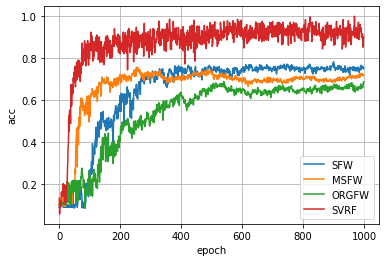

In [39]:
import matplotlib.pyplot as plt
y1 = e1['train']['acc']
x1 = range(len(y1))
y2 = e2['train']['acc']
x2 = range(len(y2))
y3 = e3['train']['acc']
x3 = range(len(y3))
y4 = e4['train']['acc']
x4 = range(len(y4))
plt.grid()
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.legend(['SFW', 'MSFW', 'ORGFW', 'SVRF'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

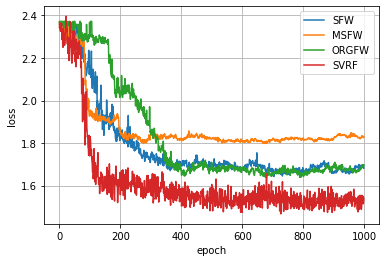

In [ ]:
import matplotlib.pyplot as plt
y1 = e1['train']['loss']
x1 = range(len(y1))
y2 = e2['train']['loss']
x2 = range(len(y2))
y3 = e3['train']['loss']
x3 = range(len(y3))
y4 = e4['train']['loss']
x4 = range(len(y4))
plt.grid()
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.legend(['SFW', 'MSFW', 'ORGFW', 'SVRF'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
t1, t2, t3, t4 = e1['time_elapsed'], e2['time_elapsed'], e3['time_elapsed'], e4['time_elapsed']
print(t1[-1])
print(t2[-1])
print(t3[-1])
print(t4[-1])

67.55097532272339
72.48769068717957
78.96828722953796
664.5340373516083


## Breast cancer dataset

In [32]:
mb1, eb1 = experiment('SGDFWl1', 4096, 120, 4, 0.02, 0.8, data='breast_cancer')
mb2, eb2 = experiment('MSGDFWl1', 4096, 120, 4, 0.02, 0.4, data='breast_cancer')
mb3, eb3 = experiment('ORGFWl1', 4096, 120, 4, 0.02, 0.7, data='breast_cancer')
mb4, eb4 = experiment('SVRFl1', 4096, 120, 4, 0.02, 0.7, data='breast_cancer')

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use red

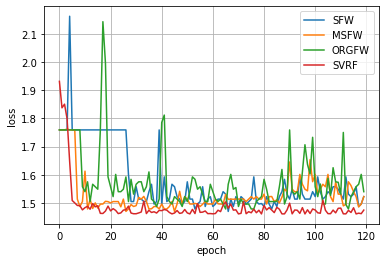

In [33]:
import matplotlib.pyplot as plt
yb1 = eb1['train']['loss']
xb1 = range(len(yb1))
yb2 = eb2['train']['loss']
xb2 = range(len(yb2))
yb3 = eb3['train']['loss']
xb3 = range(len(yb3))
yb4 = eb4['train']['loss']
xb4 = range(len(yb4))
plt.grid()
plt.plot(xb1,yb1)
plt.plot(xb2,yb2)
plt.plot(xb3,yb3)
plt.plot(xb4,yb4)
plt.legend(['SFW', 'MSFW', 'ORGFW', 'SVRF'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

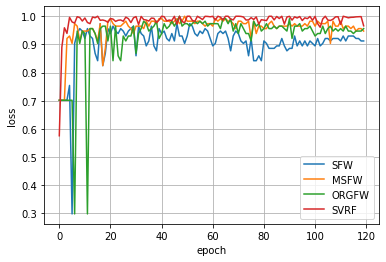

In [30]:
import matplotlib.pyplot as plt
yb1 = eb1['train']['acc']
xb1 = range(len(yb1))
yb2 = eb2['train']['acc']
xb2 = range(len(yb2))
yb3 = eb3['train']['acc']
xb3 = range(len(yb3))
yb4 = eb4['train']['acc']
xb4 = range(len(yb4))
plt.grid()
plt.plot(xb1,yb1)
plt.plot(xb2,yb2)
plt.plot(xb3,yb3)
plt.plot(xb4,yb4)
plt.legend(['SFW', 'MSFW', 'ORGFW', 'SVRF'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
tb1, tb2, tb3, tb4 = eb1['time_elapsed'], eb2['time_elapsed'], eb3['time_elapsed'], eb4['time_elapsed']
print(tb1[-1])
print(tb2[-1])
print(tb3[-1])
print(tb4[-1])

19.71240210533142
21.239089250564575
24.014136791229248
243.6100091934204
